# Influence of floating point precision on drift-diffusion simulation

This notebooks shows the numeric effects in finite volume drift-diffuion calculations. A particularly difficult case of computation is chosen, where charge carrier density is very high inside the device, but the density of current is low. Moreoever, computational grid is highly refined close to the electrode to further exagerate the numeric effects.

The sample calculation is run using with varied precision, and the results are compared. The choice of precision are:
- double precision (``np.double``), with ~15 significant digits
- extended precision (``np.float128``), with ~18 significant digits
- if possible, with quadruple precision (``oedesext.precision.qfloat``), with ~30 significant digits

Note that numpy currently ``np.float128`` uses only 80 bits to store the values, and the remaining bits are not used.

In [1]:
import numpy as np
types = [np.double, np.float128]

In [2]:
try:
    # oedesext are extensions to oedes not yet released as open-source
    import oedesext.precision
    types.append(oedesext.precision.qfloat)
except:
    oedesext=None

In [3]:
%matplotlib inline
from oedes import *
import matplotlib.pylab as plt
import scipy.constants

In [4]:
# Set up a hole only device with built-in voltage of 1V, high charge carrier 
# density on one side, minimum mesh spacing of 0.1 Å, biased with 1 mV.
b = models.BaseModel()
models.electronic_device(b, fvm.mesh1d(100e-9, dx_boundary=1e-11), 'p')
b.poisson.bc = [ models.AppliedVoltage('electrode0',calculate_current=True),
                 models.AppliedVoltage('electrode1',calculate_current=True) ]
b.setUp()
b.species[0].convergenceTest = fvm.ElementwiseConvergenceTest(
    rtol=1e-12, atol=0)
params = {
    'T': 300,
    'electrode0.voltage': 1e-3,
    'electrode0.workfunction': 0,
    'electrode1.voltage': 0,
    'electrode1.workfunction': -1,
    'hole.mu': 1e-9,
    'hole.N0': 1e27,
    'hole.level': 0,
    'epsilon_r': 3}

# Residuals

The norm of residuals roughly corresponds to the floating point precision.

In [5]:
sol = {}
for t in types:
    sol[t] = solve(b, np.asarray(b.X, dtype=t), params, maxiter=30)
    residuals = b.residuals(0., sol[t], 0. * sol[t],params)
    print('%20s |F|=%e' %(t,np.linalg.norm(residuals)))

<class 'numpy.float64'> |F|=1.339959e+23
<class 'numpy.float128'> |F|=4.496999e+19
<class 'quad.qfloat'> |F|=1.742487e+05


# Numeric estimation of charge carrier density

All solutions are the same.

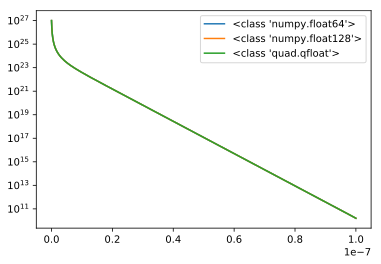

In [6]:
for t in types:
    o = b.output(0., sol[t], 0. * sol[t], params)
    plt.plot(b.poisson.mesh.cells['center'],np.abs(o['hole.c']),label=t)
plt.yscale('log')
plt.legend(loc=0);

# Numeric current density

Despite that all solutions are correct, not all estimations of current are correct:
- estimation ``electrode1.Jboundary``, based on current density at x=100 nm, is correct for all precisions
- estimation ``electrode0.Jbounary``, based on current density at x=0 nm, is wrong for all except precisions except for quadruple precision
- averaged estimation ``J``, based on Ramo-Shockley theorem, is moderately accurate, and, in this example, sufficient in extended precision

In [7]:
for t in types:
    out = b.output(0, sol[t], 0. * sol[t], params)
    d=dict(t=t,J=out['J'],Jb0=out['electrode0.Jboundary'],
           Jb1=out['electrode1.Jboundary'])
    print('{t!s} J={J:e} J_boundary={Jb0:e},{Jb1:e}'.format(**d))

<class 'numpy.float64'> J=-3.605156e-11 J_boundary=2.846323e-07,8.182311e-13
<class 'numpy.float128'> J=8.181960e-13 J_boundary=-2.779613e-11,8.182311e-13
<class 'quad.qfloat'> J=8.182311e-13 J_boundary=-8.182311e-13,8.182311e-13


# Numeric current continuity

Below numeric current continuity close to the left electrode is plotted for
different choices of floating point precision. Surprisingly, good 
charge carrier density can be calculated despite of very estimation of 
current density.

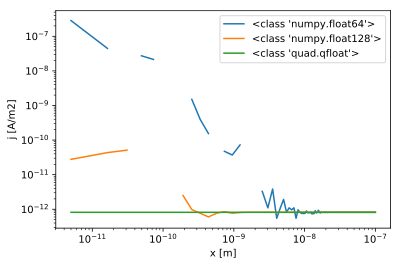

In [8]:
for t in types:
    o = b.output(0., sol[t], 0. * sol[t], params)
    j = o['hole.j'] * b.species[0].z * scipy.constants.elementary_charge
    plt.plot(b.poisson.mesh.faces['center'],np.abs(j),label=t) 
plt.yscale('log')
plt.xscale('log')
plt.xlabel('x [m]')
plt.ylabel('j [A/m2]')
plt.legend(loc=0);


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
